In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.stats as scs

!whoami
!date

ndbs
Sat Jun 27 00:14:41 PDT 2020


## Create a dataframe with flour fortification coverage data

In [6]:
coverage_levels = ['eats_fortified', 'eats_fortifiable', 'eats_vehicle']
coverage_stats = ['mean', 'lower', 'upper']

flour_df = pd.DataFrame(
    {
        'Ethiopia': [1.0, 0.0, 10.0, 15.0, 10.0, 20.0, 28.0, 23.0, 33.0],
        'India (Rajasthan)': [6.3, 4.8, 7.9, 7.1, 5.6, 9.1, 83.2, 79.5, 86.5],
        'Nigeria (Kano)': [22.7, 20.0, 25.5, 83.8, 81.4, 86.2, 83.9, 81.5, 86.3],
        'Nigeria (Lagos)': [5.4, 3.8, 6.9, 13.8, 11.5, 16.1, 14.2, 11.8, 16.5],
    },
    index = pd.MultiIndex.from_product([coverage_levels, coverage_stats])
)
# It's easiest to create the dataframe with countries as columns,
# but the transposed version looks nicer when viewing
flour_df.T

eats_fortified             eats_fortifiable              \
                            mean lower upper             mean lower upper   
Ethiopia                     1.0   0.0  10.0             15.0  10.0  20.0   
India (Rajasthan)            6.3   4.8   7.9              7.1   5.6   9.1   
Nigeria (Kano)              22.7  20.0  25.5             83.8  81.4  86.2   
Nigeria (Lagos)              5.4   3.8   6.9             13.8  11.5  16.1   

                  eats_vehicle              
                          mean lower upper  
Ethiopia                  28.0  23.0  33.0  
India (Rajasthan)         83.2  79.5  86.5  
Nigeria (Kano)            83.9  81.5  86.3  
Nigeria (Lagos)           14.2  11.8  16.5

### Create columns for India and Nigeria based on subnational estimates

This is easier to do with countries as columns, but then we transpose the dataframe to view it.

In [7]:
rajastan_weight = 1
kano_weight = 4/25
lagos_weight = 21/25

flour_df['India'] = rajastan_weight*flour_df['India (Rajasthan)']
flour_df['Nigeria'] = kano_weight*flour_df['Nigeria (Kano)'] + lagos_weight*flour_df['Nigeria (Lagos)']
flour_df.T

eats_fortified                 eats_fortifiable          \
                            mean   lower   upper             mean   lower   
Ethiopia                   1.000   0.000  10.000             15.0  10.000   
India (Rajasthan)          6.300   4.800   7.900              7.1   5.600   
Nigeria (Kano)            22.700  20.000  25.500             83.8  81.400   
Nigeria (Lagos)            5.400   3.800   6.900             13.8  11.500   
India                      6.300   4.800   7.900              7.1   5.600   
Nigeria                    8.168   6.392   9.876             25.0  22.684   

                          eats_vehicle                  
                    upper         mean   lower   upper  
Ethiopia           20.000       28.000  23.000  33.000  
India (Rajasthan)   9.100       83.200  79.500  86.500  
Nigeria (Kano)     86.200       83.900  81.500  86.300  
Nigeria (Lagos)    16.100       14.200  11.800  16.500  
India               9.100       83.200  79.500  86.500  
Nigeria            27.316       25.352  22.952  27.668

In [36]:
flour_df

Ethiopia  India (Rajasthan)  Nigeria (Kano)  \
eats_fortified   mean        1.0                6.3            22.7   
                 lower       0.0                4.8            20.0   
                 upper      10.0                7.9            25.5   
eats_fortifiable mean       15.0                7.1            83.8   
                 lower      10.0                5.6            81.4   
                 upper      20.0                9.1            86.2   
eats_vehicle     mean       28.0               83.2            83.9   
                 lower      23.0               79.5            81.5   
                 upper      33.0               86.5            86.3   

                        Nigeria (Lagos)  India  Nigeria  
eats_fortified   mean               5.4    6.3    8.168  
                 lower              3.8    4.8    6.392  
                 upper              6.9    7.9    9.876  
eats_fortifiable mean              13.8    7.1   25.000  
                 lower             11.5    5.6   22.684  
                 upper             16.1    9.1   27.316  
eats_vehicle     mean              14.2   83.2   25.352  
                 lower             11.8   79.5   22.952  
                 upper             16.5   86.5   27.668

## Define and test the coverage function

In [23]:
t_start = 1 # coverage starts one year after start of sim
r = 0.1 # unfortified food decreases by 10%/year after initial jump

def coverage(t, a, b, c, t_start=t_start, r=r):
    # return a if t < t_start else b + (c-b)*(1-(1-r)**(t-t_start)) # non-vectorized version (works for scalars)
    return np.where(t < t_start, a, b + (c-b)*(1-(1-r)**(t-t_start))) # vectorized version (t can be an array)

In [25]:
# Check that we can exponentiate an array... yep!
t = np.random.normal(2, size=10)
2**t

array([4.0907594 , 6.04900731, 3.14331687, 2.07916684, 5.36444357,
       3.65382522, 3.89639433, 6.93108424, 2.87927119, 3.78635889])

In [16]:
# Use an index slice to easily access just the means - these are a,b,c
idx = pd.IndexSlice
flour_df.loc[idx[:,'mean'], 'India']

eats_fortified    mean     6.3
eats_fortifiable  mean     7.1
eats_vehicle      mean    83.2
Name: India, dtype: float64

In [20]:
# Use argument unpacking to assign a, b, and c in the function call
coverage(2, *flour_df.loc[idx[:,'mean'], 'India'])

14.709999999999999

In [26]:
# Apply the coverage function to an array of times
coverage(t, *flour_df.loc[idx[:,'mean'], 'India'])

array([14.94317919, 18.88330128, 12.15433106,  7.54772647, 17.69836523,
       13.76111387, 14.43624901, 20.20040356, 11.20045106, 14.13617163])

In [28]:
# Compute the coverage at t = [0,1,2,3,4] to see if the values look right
# Should have coverage(0) = 6.3, coverage(1) = 7.1 - yes, looks good
coverage(np.arange(5), *flour_df.loc[idx[:,'mean'], 'India'])

array([ 6.3   ,  7.1   , 14.71  , 21.559 , 27.7231])

In [35]:
# See what we get if we plug in the 'lower' values instead
coverage(np.arange(5), *flour_df.loc[idx[:,'lower'], 'India'])

array([ 4.8   ,  5.6   , 12.99  , 19.641 , 25.6269])

In [38]:
a,b,c = flour_df.loc[idx[:,'lower'], 'India']
print(a,b,c)

4.8 5.6 79.5


## Write code to plot the coverage function

Try writing some plotting functions based on this post: https://towardsdatascience.com/creating-custom-plotting-functions-with-matplotlib-1f4b8eba6aa1

#### First plot a single country to prototype the code:

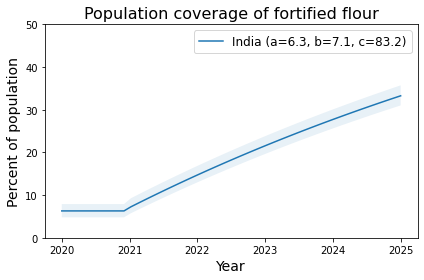

In [61]:
# Create figure with single axes object
fig, ax = plt.subplots()

# Define the time range, coverage start time, and mean coverage parameters
t = np.linspace(2020, 2025)
t_start = 2021
a,b,c = flour_df.loc[idx[:,'mean'], 'India']

# Specify options for the plot
plt_params = {'label':f'India (a={a}, b={b}, c={c})'}
fill_params = {'alpha':0.1}

# Plot the mean
ax.plot(t, coverage(t,a,b,c,t_start), **plt_params)

# Plot the lower and upper bounds
lower = coverage(t, *flour_df.loc[idx[:,'lower'], 'India'], t_start)
upper = coverage(t, *flour_df.loc[idx[:,'upper'], 'India'], t_start)
ax.fill_between(t, lower, upper, **fill_params)

# Add title, axis labels, legend
title_fontsize = 16
axis_fontsize = 14
legend_fontsize = 12

ax.set_title('Population coverage of fortified flour', fontsize=title_fontsize)
ax.set_xlabel('Year', fontsize=axis_fontsize)
ax.set_ylabel('Percent of population', fontsize=axis_fontsize)
ax.set_ylim(0,50)
ax.legend(fontsize=legend_fontsize)

fig.tight_layout()
plt.show()

In [89]:
def plot_coverage_for_location(t, t_start, coverage_df, location, ax=None, plt_kwargs={}, fill_kwargs={}):
    if ax is None: ax = plt.gca()
        
    # Compute 3 versions of the coverage function for the location,
    # based on mean, upper, and lower parameters
    idx = pd.IndexSlice
    mean, upper, lower = [coverage(t, *flour_df.loc[idx[:,val], location], t_start)
                          for val in ['mean', 'upper', 'lower']]
    
    # Plot a line for the mean and a ribbon between lower and upper
    ax.plot(t, mean, **plt_kwargs)
    ax.fill_between(t, lower, upper, **fill_kwargs)
    return ax

def plot_coverage(start_year, end_year, t_start, locations, coverage_df, vehicle):
    # Create figure with single axes object
    fig, ax = plt.subplots(figsize=(7,5))
    
    # Define the time range and coverage start time
    t = np.linspace(start_year, end_year, num=100)
    
    for location in locations:
        a,b,c = flour_df.loc[idx[:,'mean'], location]
    
        # Specify options for the plot
        plt_params = {'label':f'{location} (a={a:.1f}, b={b:.1f}, c={c:.1f})'}
        fill_params = {'alpha':0.1}
        
        plot_coverage_for_location(t, t_start, coverage_df, location,
                                   ax=ax, plt_kwargs=plt_params, fill_kwargs=fill_params)
        
    # Add title, axis labels, legend
    title_fontsize = 16
    axis_fontsize = 14
    legend_fontsize = 12

    ax.set_title(f'Population coverage of fortified {vehicle}', fontsize=title_fontsize)
    ax.set_xlabel('Year', fontsize=axis_fontsize)
    ax.set_ylabel('Percent of population', fontsize=axis_fontsize)
#     ax.set_ylim(0,50)
    ax.legend(fontsize=legend_fontsize)

    fig.tight_layout()
    return fig, ax

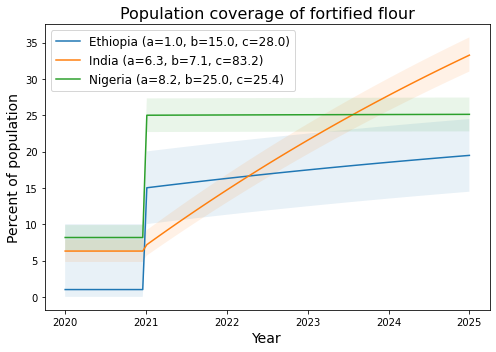

In [92]:
locations = ['Ethiopia', 'India', 'Nigeria']
plot_coverage(2020, 2025, 2021, locations, flour_df, 'flour')
plt.show()